<a href="https://colab.research.google.com/github/SokichiFujita/PyTorch-for-Deep-Learning-and-Computer-Vision/blob/master/Chapter9_CIFAR_10_Classification_Before_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #create numpy array from tensor
  image = image.transpose(1, 2, 0)
  print(image.shape)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


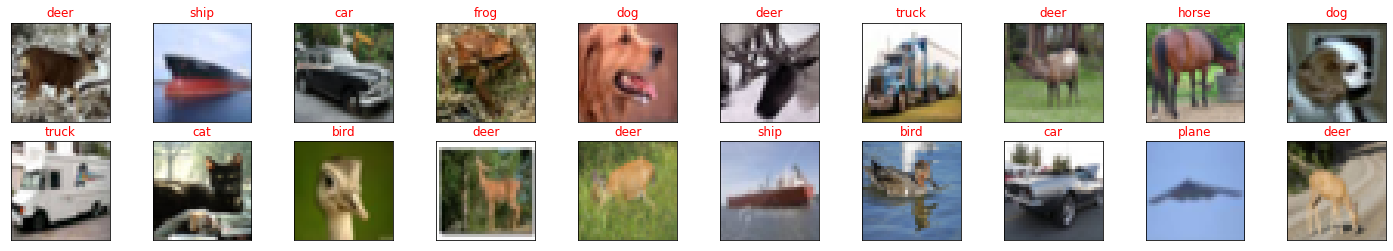

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[i]))
  ax.set_title(classes[labels[i].item()], color="red")

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(5 * 5 * 50, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [22]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [24]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: {} training loss: {:.7f}, accuracy: {:.7f} '.format(e+1, epoch_loss, epoch_acc.item()))
    print('epoch: {} validate loss: {:.7f}, accuracy: {:.7f} '.format(e+1, val_epoch_loss, val_epoch_acc.item()))


epoch: 1 training loss: 1.8418963, accuracy: 33.4300003 
epoch: 1 validate loss: 1.6169824, accuracy: 41.7999992 
epoch: 2 training loss: 1.5352818, accuracy: 44.5940018 
epoch: 2 validate loss: 1.4818971, accuracy: 46.7199974 
epoch: 3 training loss: 1.4271517, accuracy: 48.4880028 
epoch: 3 validate loss: 1.4024183, accuracy: 49.0399971 
epoch: 4 training loss: 1.3570286, accuracy: 51.5300026 
epoch: 4 validate loss: 1.3333635, accuracy: 52.0599976 
epoch: 5 training loss: 1.3066878, accuracy: 53.3320007 
epoch: 5 validate loss: 1.2835751, accuracy: 54.2500000 
epoch: 6 training loss: 1.2575875, accuracy: 55.1440010 
epoch: 6 validate loss: 1.2696103, accuracy: 54.6699982 
epoch: 7 training loss: 1.2143855, accuracy: 56.5620041 
epoch: 7 validate loss: 1.2141054, accuracy: 56.3799973 
epoch: 8 training loss: 1.1782477, accuracy: 58.0480042 
epoch: 8 validate loss: 1.1912513, accuracy: 57.2700005 
epoch: 9 training loss: 1.1432104, accuracy: 59.3380013 
epoch: 9 validate loss: 1.16457

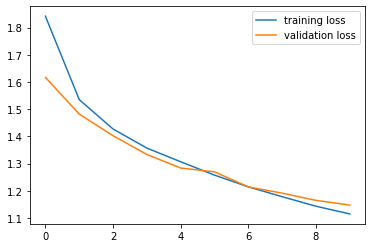

In [25]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

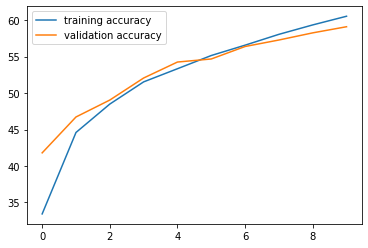

In [26]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()